## Concept implemented in this notebook taken from Building Effective agent By anthropic

    Link:   https://www.anthropic.com/engineering/building-effective-agents

## Prompt Chaining

In [3]:
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq
from typing import TypedDict,Dict, Any,List,Annotated
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import operator

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
import os
from langchain_core.messages import BaseMessage,HumanMessage,SystemMessage,AIMessage

load_dotenv()
groq_api_key  = os.getenv("GROQ_API_KEY")
if not groq_api_key:
    raise ValueError("GROQ_API_KEY not found in environment")

In [5]:
llm = ChatOpenAI(
    model="openai/gpt-oss-120b",
    temperature=0,
    max_tokens=8192,
    api_key=groq_api_key,
    base_url = "https://api.groq.com/openai/v1"
)

In [11]:
class JokeClass(TypedDict):
    topic:str
    joke:str
    imporved_joke:str
    final_joke:str

In [ ]:
def generate_joke(state:JokeClass) -> Dict[str,Any]:
    topic = state["topic"]
    prompt = f"This is the topic: {topic} , make a Joke from it"
    msg = llm.invoke(prompt)
    return {"joke":msg.content}

def improve_joke(state:JokeClass) -> Dict[str,Any]:
    Joke = state["joke"]
    prompt = f"make this Joke : {Joke} , funnier by adding wordplay"
    msg = llm.invoke(prompt)

    return {"imporved_joke":msg.content}
def polish_joke(state:JokeClass) -> Dict[str,Any]:
    imp_joke = state["imporved_joke"]
    prompt = f"add a supprising twist to this joke: {imp_joke}"
    msg = llm.invoke(prompt)

    return {"final_joke":msg.content}

def check_punchline(state:JokeClass)-> Dict[str,Any]:
    if "?" in state["joke"] or "!" in  state["joke"]:
        return "Pass"
    return "Fail"

In [13]:
graph = StateGraph(JokeClass)
graph.add_node("generate_joke",generate_joke)
graph.add_node("improve_joke",improve_joke)
graph.add_node("polish_joke",polish_joke)

graph.add_edge(START,"generate_joke")
graph.add_conditional_edges("generate_joke",check_punchline, {"Pass":"improve_joke","Fail":END})
graph.add_edge("improve_joke","polish_joke")
graph.add_edge("polish_joke",END)

workflow = graph.compile()
workflow.invoke({"topic":"recaptcha"})

{'topic': 'recaptcha',
 'joke': 'Sure, here’s a light‑hearted one:\n\n> **Why did the website break up with its reCAPTCHA?**  \n> Because every time it tried to get close, the reCAPTCHA kept saying, “I’m not a robot… but I’m still not feeling it!”',
 'imporved_joke': '**Why did the website dump its reCAPTCHA?**  \n\nBecause every time it tried to get *close*—or even just *click*—the reCAPTCHA kept throwing a “*human* error”:  \n\n> “I’m not a robot, but I’m still not *feeling* the *connection*—you’re just too *script‑y* for me!”  \n\n*Bonus wordplay:* The site tried to *debug* the relationship, but the reCAPTCHA kept insisting it needed *more *CAPTCHA*tion* before any *login* could happen.',
 'final_joke': "**Why did the website dump its reCAPTCHA?**  \n\nBecause every time it tried to get *close*—or even just *click*—the reCAPTCHA kept throwing a “*human* error”:  \n\n> “I’m not a robot, but I’m still not *feeling* the *connection*—you’re just too *script‑y* for me!”  \n\n*Bonus wordp

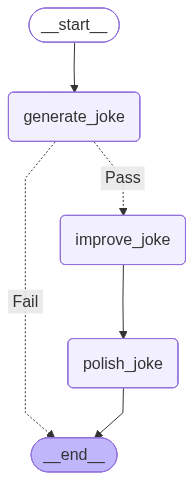

In [14]:
workflow

## Parallelization

In [54]:
from langgraph.graph.message import add_messages


class State(TypedDict):
    topic:str
    Joke:str
    Poem:str
    Story:str
    combined_output:Annotated[list,add_messages]

In [55]:
def generate_joke(state:State) -> Dict[str,Any]:
    topic = state["topic"]
    prompt = f"Generate the joke with this topic: {topic}"
    
    msg = llm.invoke(prompt)

    return {"Joke":msg.content,"combined_output":[msg]}

def generate_poem(state:State) -> Dict[str,Any]:
    topic = state["topic"]
    prompt = f"Generate the Poem with this topic: {topic}"
    
    msg = llm.invoke(prompt)

    return {"Poem":msg.content,"combined_output":[msg]}

def generate_story(state:State) -> Dict[str,Any]:
    topic = state["topic"]
    prompt = f"Generate the story with this topic: {topic}. Maximum 100 words striclty."
    
    msg = llm.invoke(prompt)

    return {"Story":msg.content,"combined_output":[msg]}

def combined_outputs(state:State) -> Dict[str,Any]:
    return {"combined_output":state["combined_output"]}




In [56]:
graph = StateGraph(State)
graph.add_node("generate_joke",generate_joke)
graph.add_node("generate_poem",generate_poem)
graph.add_node("generate_story",generate_story)
graph.add_node("combined_output",combined_outputs)

graph.add_edge(START,"generate_joke")
graph.add_edge(START,"generate_poem")
graph.add_edge(START,"generate_story")
graph.add_edge("generate_joke","combined_output")
graph.add_edge("generate_poem","combined_output")
graph.add_edge("generate_story","combined_output")
graph.add_edge("combined_output",END)

In [57]:
workflow = graph.compile()

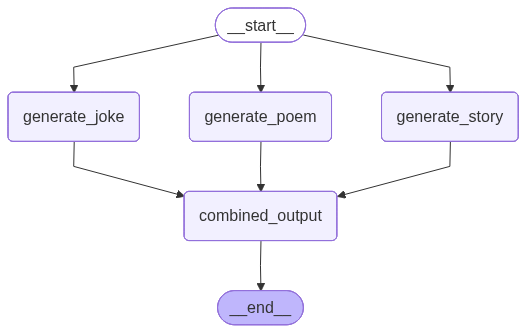

In [58]:
workflow

In [59]:
workflow.invoke({"topic":"pizza"})

{'topic': 'pizza',
 'Joke': 'Why did the pizza apply for a job?\n\nBecause it heard the company was looking for someone with a lot of *dough* and great *delivery* skills! 🍕😄',
 'Poem': '**Ode to the Circle of Delight**\n\nIn a humble oven’s amber glow,  \nA doughy moon begins to rise,  \nIts fragrant sighs of yeast‑kissed air  \nInvite the world to close its eyes.\n\nA ruby river, sauce, spreads wide—  \nTomatoes crushed, a sun‑kissed tide,  \nGarlic whispers, basil sighs,  \nA fragrant promise, deep inside.\n\nThen cheese, a snowy blanket soft,  \nMelted rivers, golden streams,  \nStretching ribbons, pulling hearts,  \nA molten hug of dairy dreams.\n\nPepperoni moons, crisp‑edged stars,  \nMushroom caps like forest crowns,  \nOlives black as midnight’s wink,  \nAnd peppers bright as sunrise towns.\n\nThe crust, a sturdy, caramel crust,  \nA crunch that sings of grain and fire,  \nA sturdy base for all that rides—  \nA canvas for the chef’s desire.\n\nSlice by slice, the world unites, 

## Routing

In [61]:
from typing import Literal
from pydantic import BaseModel,Field
class Route(BaseModel):
    intent : Literal["poem","story","joke"] = Field(None,description="The next step in the routing process")


route = llm.with_structured_output(Route)

In [64]:
class State(TypedDict):
    input:str
    decision:str
    output:str


In [66]:
def generate_joke(state:State) -> Dict[str,Any]:
    topic = state["input"]
    prompt = f"Generate the joke with this topic: {topic}"
    
    msg = llm.invoke(prompt)

    return {"output":msg.content}

def generate_poem(state:State) -> Dict[str,Any]:
    topic = state["input"]
    prompt = f"Generate the Poem with this topic: {topic}"
    
    msg = llm.invoke(prompt)

    return {"output":msg.content}

def generate_story(state:State) -> Dict[str,Any]:
    topic = state["input"]
    prompt = f"Generate the story with this topic: {topic}. Maximum 100 words striclty."
    
    msg = llm.invoke(prompt)

    return {"output":msg.content}

def llm_routing(state:State) -> Dict[str,Any]:
    user_message = state["input"]
    prompt = [SystemMessage(content="Route the input to joke, poem ,story on the user requests"),
              HumanMessage(content=f"{user_message}")]
    decision = route.invoke(prompt)

    return {"decision":decision.intent}

def route_decision(state:State) -> Dict[str,Any]:
    decision = state["decision"]

    if decision == "poem":
        return "generate_poem"
    elif decision == "story":
        return "generate_story"
    elif decision == "joke":
        return "generate_joke"

graph = StateGraph(State)
graph.add_node("generate_joke",generate_joke)
graph.add_node("generate_story",generate_story)
graph.add_node("generate_poem",generate_poem)
graph.add_node("llm_routing",llm_routing)

graph.add_edge(START,"llm_routing")
graph.add_conditional_edges("llm_routing",route_decision,{
    "generate_joke":"generate_joke",
    "generate_poem": "generate_poem",
    "generate_story": "generate_story"
})

graph.add_edge("generate_joke",END)
graph.add_edge("generate_poem",END)
graph.add_edge("generate_story",END)

workflow = graph.compile()





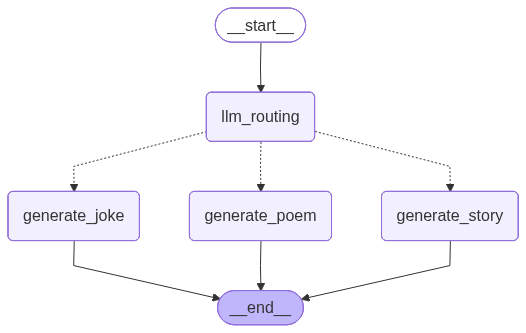

In [67]:
workflow

In [69]:
workflow.invoke({"input":"write a good poem about the nature."})

{'input': 'write a good poem about the nature.',
 'decision': 'poem',
 'output': '**Whispers of the Wild**\n\nIn the hush before sunrise, the meadow sighs,  \na sea of green that rolls beneath a trembling sky.  \nEach blade of grass, a silvered harp string,  \nplucked by the breath of wind, a soft, unseen hymn.\n\nThe river—silver thread through stone‑stitched lace—  \ncarries stories of mountains, of rain‑kissed valleys,  \nits surface a mirror where clouds learn to dance,  \nand minnows dart like thoughts in a wandering mind.\n\nLeaves unfurl like ancient scrolls, inked in chlorophyll,  \ntheir veins mapping the veins of the earth itself.  \nSunlight drips gold through the canopy,  \npainting the forest floor with patches of fire.\n\nBirdsong erupts—a chorus of sunrise,  \nwarbles and trills that stitch the day together,  \nwhile the owl’s night‑song, low and patient,  \nholds the moon in a gentle, feathered embrace.\n\nMountains stand as old sentinels,  \ntheir peaks crowned with sn

## Orchestrator Worker

In [76]:
from operator import add

class Section(BaseModel):
    name:str = Field(
        description="Name for this section of the report.",
    )
    description:str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section."
    )

class Sections(BaseModel):
    sections:List[Section] = Field(
        description="Section of the report."
    )

planner = llm.with_structured_output(Sections)

In [77]:
class State(TypedDict):
    topic:str
    sections:list[str]
    completed_sections:Annotated[list,add]
    final_report:str

class WorkerState(TypedDict):
    section:Section
    completed_sections:Annotated[list,add]

In [82]:
from langgraph.constants import Send

def orchestrator(state:State) -> Dict[str,Any]:
    """
    Orchestrator that generate a plan for the report
    """
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic : {state["topic"]}")
        ]
    )
    print(f"sections schema :{report_sections.sections}")
    return {"sections":report_sections.sections}

def llm_call(state:WorkerState) -> Dict[str,Any]:
    """Worker writes a section of the report"""
    section = llm.invoke(
        [SystemMessage(content = "Write a report section."),
         HumanMessage(content=f"Here is the section name: {state["section"].name} and description: {state["section"].description}")]    
    )
    return {"completed_sections":[section.content]}

def synthesizer(state:State) -> Dict[str,Any]:
    """
    Synthesize full report from sections
    """
    completed_sections = state["completed_sections"]
    completed_report_sections = "\n\n----\n\n".join(completed_sections)

    return {"final_report":completed_report_sections}

def assign_workers(state:State) -> List:
    print(f"state sections{state["sections"]}")
    return [Send("llm_call",{"section":s}) for s in state["sections"]]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_27912\1017168675.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [83]:
orchestrator_worker_builder = StateGraph(State)

orchestrator_worker_builder.add_node("orchestrator",orchestrator)
orchestrator_worker_builder.add_node("llm_call",llm_call)
orchestrator_worker_builder.add_node("synthesizer",synthesizer)

orchestrator_worker_builder.add_edge(START,"orchestrator")
orchestrator_worker_builder.add_conditional_edges("orchestrator",assign_workers,["llm_call"])
orchestrator_worker_builder.add_edge("llm_call","synthesizer")
orchestrator_worker_builder.add_edge("synthesizer",END)

orchestrator_worker = orchestrator_worker_builder.compile()

In [88]:
worker = orchestrator_worker.invoke({"topic":"Building Effective Agent"})

sections schema :[Section(name='Introduction', description="Overview of the report's purpose, importance of building effective agents, and outline of the structure."), Section(name='Fundamentals of Agent Design', description='Explanation of core concepts such as autonomy, reactivity, proactiveness, and social ability, and their relevance to effectiveness.'), Section(name='Problem Definition and Requirements Gathering', description='Methods for defining agent goals, environment, constraints, and performance metrics.'), Section(name='Architecture and Modeling', description='Discussion of common architectures (reactive, deliberative, hybrid), modeling techniques, and selection criteria.'), Section(name='Learning and Adaptation Strategies', description='Overview of machine learning, reinforcement learning, and online adaptation techniques for agents.'), Section(name='Communication and Coordination', description='Strategies for inter‑agent communication, protocols, negotiation, and teamwork

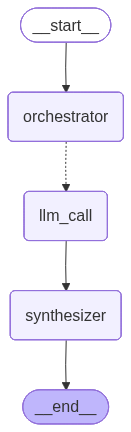

In [85]:
orchestrator_worker

In [89]:
worker["sections"]

[Section(name='Introduction', description="Overview of the report's purpose, importance of building effective agents, and outline of the structure."),
 Section(name='Fundamentals of Agent Design', description='Explanation of core concepts such as autonomy, reactivity, proactiveness, and social ability, and their relevance to effectiveness.'),
 Section(name='Problem Definition and Requirements Gathering', description='Methods for defining agent goals, environment, constraints, and performance metrics.'),
 Section(name='Architecture and Modeling', description='Discussion of common architectures (reactive, deliberative, hybrid), modeling techniques, and selection criteria.'),
 Section(name='Learning and Adaptation Strategies', description='Overview of machine learning, reinforcement learning, and online adaptation techniques for agents.'),
 Section(name='Communication and Coordination', description='Strategies for inter‑agent communication, protocols, negotiation, and teamwork.'),
 Sectio

## Evaluator - Optimizer

In [98]:
class Feedback(BaseModel):
    grade: Literal["funny","not funny"] = Field(description="Decide if the joke is funny or not")
    feedback: str = Field(description="if the joke is not funny provide feedback on how to improve it")

evaluator = llm.with_structured_output(Feedback)

In [99]:
class State(TypedDict):
    joke:str
    topic:str
    feedback:str
    funny_or_not:str

In [100]:
def llm_generator_joke(state:State) -> Dict[str,Any]:
    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state["topic"]} but take into account this feedback abot joke: {state["feedback"]}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state["topic"]}")
    
    return {"joke":msg.content}

def llm_call_evaluator(state:State) -> Dict[str,Any]:
    grade = evaluator.invoke(f"Grade the joke: {state["joke"]}")
    return {"funny_or_not":grade.grade,"feedback":grade.feedback}

def llm_routing(state:State) -> Dict[str,Any]:
    grade = state["funny_or_not"]
    if grade == "funny":
        return "Accepted"
    else:
        return "Rejected + Feedback"


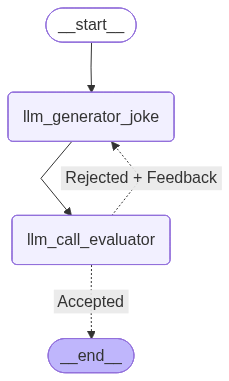

In [101]:
optimizer_builder = StateGraph(State)
optimizer_builder.add_node("llm_generator_joke",llm_generator_joke)
optimizer_builder.add_node("llm_call_evaluator",llm_call_evaluator)

optimizer_builder.add_edge(START,"llm_generator_joke")
optimizer_builder.add_edge("llm_generator_joke","llm_call_evaluator")
optimizer_builder.add_conditional_edges("llm_call_evaluator",llm_routing,{
    "Accepted":END,
    "Rejected + Feedback":"llm_generator_joke"
})
workflow = optimizer_builder.compile()
workflow

In [102]:
workflow.invoke({"topic":"pizza"})

{'joke': 'Why did the pizza apply for a job?\n\nBecause it heard the company was looking for someone with *dough*‑mestic skills and a *crust*‑worthy work ethic! 🍕😄',
 'topic': 'pizza',
 'feedback': 'The joke uses clever pizza‑related wordplay (dough‑mestic, crust‑worthy) and the emoji adds a playful tone, making it light‑hearted and enjoyable.',
 'funny_or_not': 'funny'}

## AGENT

In [108]:
from langchain.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add,multiply,divide]

tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)



In [109]:
from langgraph.graph import MessagesState
from langchain_core.messages import ToolMessage

def llm_call(state:MessagesState):

    return {
        "messages":[
            llm_with_tools.invoke(
                [
                    SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")
                ]
                +state["messages"]
            )
        ]
    }

def tool_node(state:dict):
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation,tool_call_id = tool_call["id"]))
    return {"messages":result}

def should_continue(state:MessagesState) -> Literal["environment", END]:
    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user) 
    return END

agent_builder = StateGraph(MessagesState)



In [110]:
agent_builder.add_node("llm_call",llm_call)
agent_builder.add_node("environment",tool_node)

agent_builder.add_edge(START,"llm_call")
agent_builder.add_conditional_edges("llm_call",should_continue,{
    "Action":"environment",
    END:END,
})
agent_builder.add_edge("environment", "llm_call")

agent = agent_builder.compile()



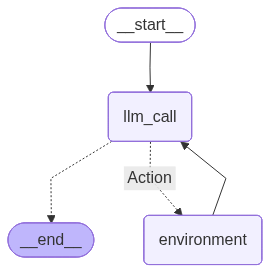

In [111]:
agent

In [112]:
messages = [HumanMessage(content="Add 3 and 4. Then, take the output and multiple by 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Then, take the output and multiple by 4.
================================== Ai Message ==================================
Tool Calls:
  add (fc_764276ba-64e4-4138-929f-8d806bd4a682)
 Call ID: fc_764276ba-64e4-4138-929f-8d806bd4a682
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_90922591-6941-43ea-beb0-972cb50eedab)
 Call ID: fc_90922591-6941-43ea-beb0-972cb50eedab
  Args:
    a: 7
    b: 4
================================= Tool Message =================================

28
================================== Ai Message ==================================

The result of adding 3 and 4, then multiplying the sum by 4, is **28**.
